In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.decomposition import PCA
from matplotlib.colors import BoundaryNorm

#### !!! copy in /train: Crontrol1 Mutant1 Mutant2
#### !!! copy in /test:  Crontrol2 Mutant3 Mutant4


In [ ]:
# Path to data
ROOT = Path.home() / "Documents/project_004/data/data_small_zfish/train"

# Load all tiff stacks
tiff_paths = sorted(ROOT.glob("*.tif"))
print("Found stacks:", len(tiff_paths))

stacks = []
embryo_ids = []
lengths = []

for p in tiff_paths:
    arr = tiff.imread(str(p)).astype(np.float32)  # shape: (T_i, H, W)
    stacks.append(arr)
    embryo_ids.append(p.stem)
    lengths.append(arr.shape[0])

total_frames = sum(lengths)
print("Total frames across all stacks:", total_frames)

# Metadata per frame (embryo_id, frame index)
frame_embryo = np.concatenate([[eid] * L for eid, L in zip(embryo_ids, lengths)])
frame_idx = np.concatenate([np.arange(L) for L in lengths])

dfmeta = pd.DataFrame({
    "embryo_id": frame_embryo,
    "frame_idx": frame_idx
})
dfmeta.head(), dfmeta.shape


Found stacks: 6
Total frames across all stacks: 2700


(  embryo_id  frame_idx
 0  Control1          0
 1  Control1          1
 2  Control1          2
 3  Control1          3
 4  Control1          4,
 (2700, 2))

In [ ]:
class AEDataset(Dataset):
    def __init__(self, stacks, noise_std=0.0, crop_size=None):
        """
        stacks : list of np.ndarray, each with shape (T_i, H, W)
        noise_std : float, std of optional Gaussian noise. 0.0 = plain AE
        crop_size : tuple, (height, width) of random crop, or None for full frame
        """
        self.stacks = [s.astype(np.float32) for s in stacks]

        # Build global index: (stack_idx, frame_idx)
        self.index = []
        for stack_idx, s in enumerate(self.stacks):
            T = s.shape[0]
            for t in range(T):
                self.index.append((stack_idx, t))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        stack_idx, t = self.index[idx]
        img = self.stacks[stack_idx][t]  # (H, W)

        # Normalize to [0, 1]
        img = img.astype(np.float32)
        img -= img.min()
        if img.max() > 0:
            img = img / img.max()

        # Add channel dimension -> (1, H, W)
        if img.ndim == 2:
            img = img[None, :, :]  # (1, H, W)

        image = torch.from_numpy(img)

        return image.float(), image.float()

In [ ]:
full_dataset1 = AEDataset(stacks=stacks)

print("AE dataset length (frames):", len(full_dataset1))
print("dfmeta rows:", dfmeta.shape[0])


AE dataset length (frames): 2700
dfmeta rows: 2700


In [ ]:
train_size1 = int(0.8 * len(full_dataset1))
val_size1 = len(full_dataset1) - train_size1
train_ds1, val_ds1 = random_split(full_dataset1, [train_size1, val_size1])

batch_size = 16

train_loader1 = DataLoader(train_ds1, batch_size=batch_size, shuffle=True)
val_loader1   = DataLoader(val_ds1, batch_size=batch_size, shuffle=False)
len(train_loader1), len(val_loader1)


# !!!! Create data loader for test

####  "Documents/project_004/data/data_small_zfish/test"

##test_loader =


(135, 34)

In [ ]:
class AutoEncoder_nosup(nn.Module):
    def __init__(self, latent_dim=32, input_size=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        # compute encoder output shape
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_size, input_size)
            h = self.encoder(dummy)
        self.enc_out_shape = h.shape[1:]           # (C, H, W)
        enc_out_dim = h.numel()                    # C * H * W

        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, enc_out_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, *self.enc_out_shape)
        x_hat = self.decoder(h)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32

model1 = AutoEncoder_nosup(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)


In [ ]:
def train_ae_nosup(model1, train_loader1, val_loader1, optimizer, criterion, device, epochs=100, patience=5):
    model1.to(device)
    history1 = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        #TRAIN
        model1.train()
        train_loss = 0.0
        for noisy, clean in train_loader1:
            noisy = noisy.to(device)
            clean = clean.to(device)

            optimizer.zero_grad()
            output = model1(noisy)
            loss = criterion(output, clean)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)

        train_loss /= len(train_loader1.dataset)

        # VALIDATION
        model1.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader1:
                noisy = noisy.to(device)
                clean = clean.to(device)

                output = model1(noisy)
                loss = criterion(output, clean)
                val_loss += loss.item() * noisy.size(0)

        val_loss /= len(val_loader1.dataset)

        history1['train_loss'].append(train_loss)
        history1['val_loss'].append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model1.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return history1

In [ ]:
history1 = train_ae_nosup(model1, train_loader1, val_loader1, optimizer, criterion, device, epochs=200, patience=1)

Epoch 001 | Train Loss: 0.001097 | Val Loss: 0.001455
Epoch 002 | Train Loss: 0.001089 | Val Loss: 0.001440
Epoch 003 | Train Loss: 0.001070 | Val Loss: 0.001443
Early stopping triggered at epoch 3


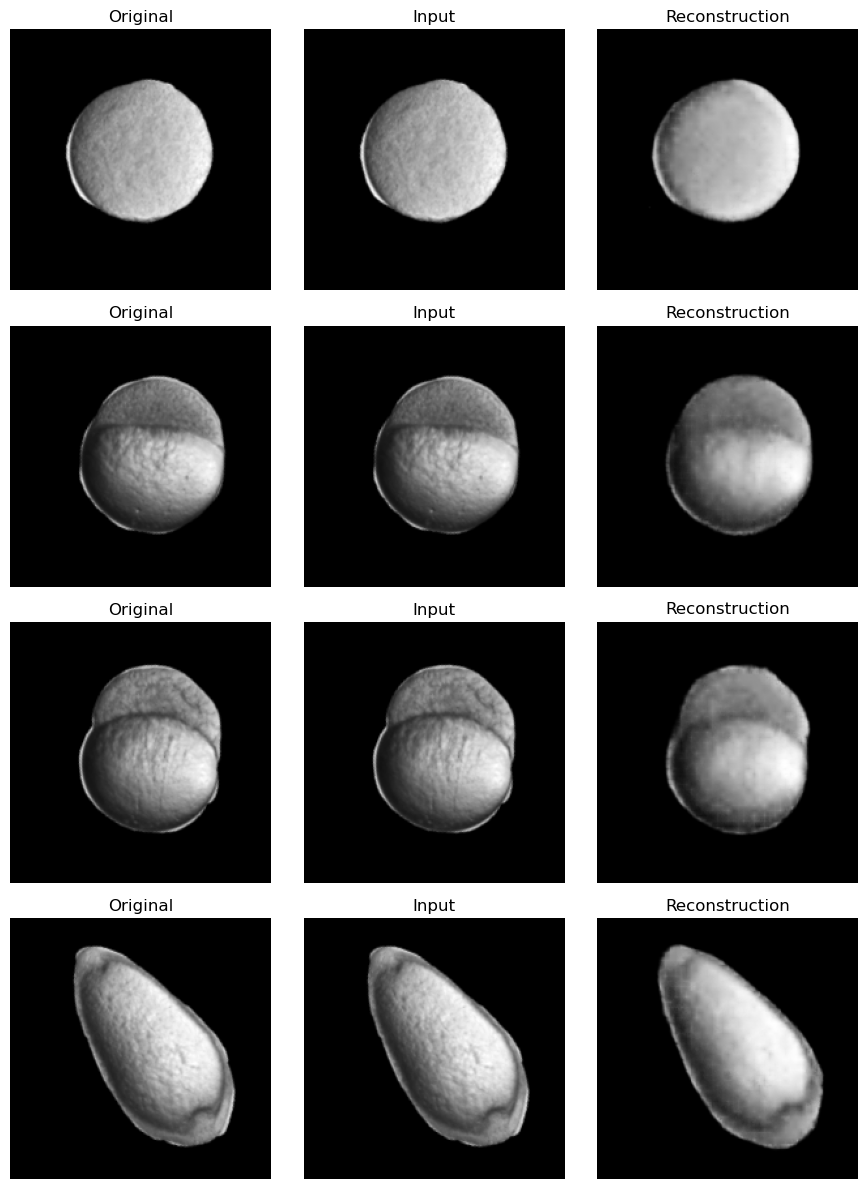

In [ ]:
model1.eval()
noisy_batch, clean_batch = next(iter(test_loader))
noisy_batch = noisy_batch.to(device)
with torch.no_grad():
    recon_batch = model1(noisy_batch)

noisy_batch = noisy_batch.cpu().numpy()
clean_batch = clean_batch.numpy()
recon_batch = recon_batch.cpu().numpy()

n_show = 4
plt.figure(figsize=(9, 3*n_show))
for i in range(n_show):
    # original
    plt.subplot(n_show, 3, 3*i + 1)
    plt.imshow(clean_batch[i, 0], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # input
    plt.subplot(n_show, 3, 3*i + 2)
    plt.imshow(noisy_batch[i, 0], cmap="gray")
    plt.title("Input")
    plt.axis("off")

    # reconstruction
    plt.subplot(n_show, 3, 3*i + 3)
    plt.imshow(recon_batch[i, 0], cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

plt.tight_layout()
plt.show()


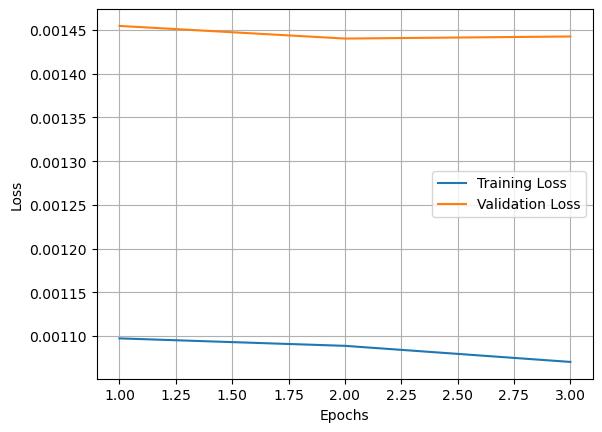

In [ ]:
train_losses = history1['train_loss']
val_losses   = history1['val_loss']

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def extract_latent_ae(model1, dataset, device):
    model1.eval()
    latents = []

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for noisy, clean in loader:
            noisy = noisy.to(device)
            z = model1.encode(noisy)
            latents.append(z.cpu())

    Z = torch.cat(latents, dim=0)
    return Z

Z_ae = extract_latent_ae(model1, full_dataset1, device)
Z_ae.shape


torch.Size([2700, 32])

In [ ]:
Z_ae_np = Z_ae.numpy()
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z_ae_np)

Z_pca.shape  # (2700, 2)


(2700, 2)

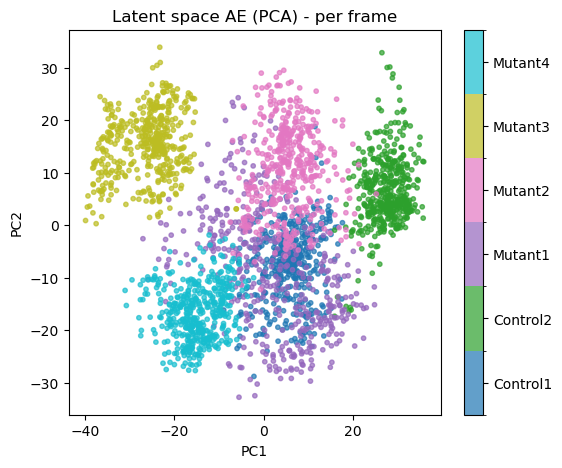

In [ ]:
embryo_labels = dfmeta["embryo_id"].values

# Unique embryo IDs
embryo_ids = np.unique(embryo_labels)          # array of 6 IDs
unique_embryos = {e: i for i, e in enumerate(embryo_ids)}
colors = [unique_embryos[e] for e in embryo_labels]

# discrete colormap with exactly 6 colors
cmap = plt.get_cmap("tab10", len(embryo_ids))
bounds = np.arange(-0.5, len(embryo_ids) + 0.5)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z_pca[:, 0], Z_pca[:, 1],
    c=colors,
    s=10,
    alpha=0.7,
    cmap=cmap,
    norm=norm
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Latent space AE (PCA) - per frame")

cbar = plt.colorbar(sc, ticks=range(len(embryo_ids)))
cbar.ax.set_yticklabels(embryo_ids)  # show real embryo IDs

plt.show()


In [ ]:
## UMAP